<a href="https://colab.research.google.com/github/1900690/Agro-Meteorological-Grid-Square-Data/blob/main/1km%E3%83%A1%E3%83%83%E3%82%B7%E3%83%A5%E6%B0%97%E8%B1%A1%E6%83%85%E5%A0%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#農研機構 メッシュ農業気象データシステムの使い方

観測・計算方法についての論文

[実況値と数値予報，平年値を組み合わせたメッシュ気温・降水量データの作成](https://www.jstage.jst.go.jp/article/cib/16/0/16_J-16-028/_article/-char/ja/)

In [11]:
#@title 利用登録時に申請したIDとパスワードを入力
# ライブラリ（メッシュデータ処理のために必要）
!pip install -q netCDF4
!pip install -q japanize-matplotlib
import numpy as np
import os
import sys
import shutil
from google.colab import userdata
import japanize_matplotlib
japanize_matplotlib.japanize()

ID = '' # @param {type:"string"}
passward = '' # @param {type:"string"}
#ID= userdata.get("ID")
#passward= userdata.get("passward")

if os.path.exists('/content/AMGSDS_map.html'):
  os.remove('/content/AMGSDS_map.html')

!wget -q https://github.com/1900690/Agro-Meteorological-Grid-Square-Data/releases/download/amd_tools4/amd_tools4.zip
!wget -q https://github.com/1900690/Agro-Meteorological-Grid-Square-Data/releases/download/AMGSDS_map/AMGSDS_map.html

shutil.unpack_archive('/content/amd_tools4.zip')
os.remove('/content/amd_tools4.zip')
sys.path.append('/content/AMD_Tools4.py')#passを通す


path = "/content/AMD_Tools4.py"
line_num = 50 # 上書きする行番号(場合によっては変わる)
tempid = "USER='"+ID+"'\n" # 上書きしたい内容
temppass = "PASSWORDS=['"+passward+"','"+passward+"']\n" # 上書きしたい内容
font="plt.rcParams['font.family'] = 'Meiryo'\n"

with open(path) as file:
    list = file.readlines()
list[line_num] = tempid
list[line_num+1] = temppass
list[line_num+38] = font
with open(path, mode="w") as file:
    file.writelines(list)


import AMD_Tools4 as amd

# 気象データの取得


## 1 関数 GetMetData
メッシュ日別気象データは、ライブラリ AMD_Tools4 に収録される関数 GetMetData で取得します。

```Python
AMD_Tools4.GetMetData(nani, itsu, doko, cli=False, namuni=False, url='https://amd.rd.naro.go.jp/opendap/AMD/')
```
引数(必須)：<br>
* **nani**： 気象要素記号で、'TMP_mea'などの文字列で与える
* **itsu**： 取得するデータの時間範囲で、['2008-05-05', '2009-05-05'] のように文字列の2要素リストで与える。特定の日のデータを取得するときは二カ所に同じ日付を与える。
* **doko**： 取得するデータの緯度と経度の範囲を、[36.0, 40.0, 130.0, 135.0] のように緯度経度の順で範囲の最小値と最大値を十進小数で指定する。特定地点のデータを取得するときは、それぞれの最小値と最大値に同じ値を与える。
  
引数(必要なときだけ使用)：<br>
* **cli**: cli=True とすると気象値ではなく平年値が返される。
* **namuni**: namuni=True とすると、関数の戻り値に、気象要素の正式名称と単位が追加される。
* **url**: 気象データを取り出す場所を指定する。省略した場合は**農研機構のデータ配信サーバー** からデータを取得する。

戻り値：<br>
* **第1戻り値**： 指定した気象要素の３次元(時刻、緯度、経度) 配列。範囲の指定の仕方にかかわらず常に３次元となる。
* **第2戻り値**： 切り出した気象データの日付の１次元配列。値はdatetimeオブジェクト。
* **第3戻り値**： 切り出した気象データの緯度の１次元配列。値は浮動小数。
* **第4戻り値**： 切り出した気象データの経度の１次元配列。値は浮動小数。
* **第5戻り値**(引数に namuni=True を加えたときのみ)： 気象データの正式名。文字列。
* **第6戻り値**(引数に namuni=True を加えたときのみ)： 気象データの単位。文字列。


#### 参考
　取得する緯度経度範囲を地図を見ながら定めるには、以下のサイトを利用します。<br>
 https://amu.rd.naro.go.jp/wiki_open/lib/exe/fetch.php?media=wiki:about:mapl_ver2.1.html

 （開かない場合は、メッシュ農業気象データHPトップ＜ https://amu.rd.naro.go.jp/wiki_open/ ＞→登録利用者専用ページ にある、緯度経度確認HTMLファイルをダウンロードして利用してください。）

　指先型のカーソルで地図上の地点をクリックすると、ブラウザ左下に、その地点の緯度経度が表示されるので、それをコピーして下さい。表示の小数桁は大変長いですが、大雑把に言って、0.00001度が地上の1メートルぐらいなので、長く書き込んでも意味はありません。<br>
　なお、表示される地図の1次メッシュや3次メッシュの格子は表示/非表示を切り替えることができます。

　3次メッシュコードが分かっていて、その中心緯度経度が知りたいときは、ライブラリ **AMD_Tools4** が提供する関数 **mesh2lalo** を使用してください。

In [ ]:
#@title 調べる場所の経度と緯度を調べる
#@markdown ←の➤を押してファイルをダウンロード、そのファイルを開き情報が欲しい区画の経度と緯度をコピーする
from google.colab import files
files.download('/content/AMGSDS_map.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2 データの取得
　高知県の室戸岬先端周辺の、下図に示す 30 メッシュの領域の気象データを実際に取得してみましょう。気象要素は日平均気温、期間は2023年6月1日～6月3日とします。

　関数 GetMetData の第１引数に与える気象要素の記号は、日平均気温に対しては **TMP_mea** です。なお、気象要素に与えられている記号は下記リンクで確認することができます。<br>
https://amu.rd.naro.go.jp/wiki_open/doku.php?id=about#多彩な気象要素が用意されています

　第２引数に与える期間のリストは、期間の初めと終わりの日付を文字列で与えればよいので、 **['2023-06-01','2023-06-03']** となります。

　関数、GetMetData は、第３引数で指定した領域に少しでも掛かれば、そのメッシュのデータも取得する仕様なので、範囲指定の際、メッシュ範囲外縁の緯度経度を与えると、数値の丸めの関係から、余分な３次メッシュが取得されることがあります。これを避けたい場合は、外縁ではなくメッシュの中心点の緯度経度座標を与えるとよいでしょう。このやり方では、第３引数に与えるリストは **[33.2375, 33.2792, 134.1437, 134.1938]** となります。


In [12]:
#@markdown ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigou = [['日平均気温', 'TMP_mea'], ['日最高気温', 'TMP_max'], ['日最低気温', 'TMP_min'], ['降水量', 'APCP'], ['1mm以上の降水の有無', 'OPR'], ['日照時間', 'SSD'], ['全天日射量', 'GSR'], ['下向き長波放射量', 'DLR'], ['日平均相対湿度', 'RH'], ['日平均風速', 'WIND'], ['積雪深', 'SD'], ['積雪相当水量', 'SWE'], ['日降雪相当水量', 'SFW'], ['予報気温の確からしさ', 'PTMP']]
#情報名を入力する
欲しい情報 = '日平均気温' # @param ["日平均気温", "日最高気温", "日最低気温", "降水量", "1mm以上の降水の有無", "日照時間", "全天日射量", "下向き長波放射量", "日平均相対湿度", "日平均風速", "積雪深", "積雪相当水量", "日降雪相当水量", "予報気温の確からしさ"]
#リスト（情報名）の中から入力した都市名と一致するものを検索する
for i in yousokigou:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigou.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigou[j][1]

#@markdown 期間の指定
初め= '2018-03-22' # @param {type:"date"}
終わり = '2018-03-22' # @param {type:"date"}
itsu= [初め, 終わり]

#@markdown 位置の指定
緯度 = 33.2375 # @param {type:"number"}
経度 = 134.1437 # @param {type:"number"}

doko= [緯度,緯度,経度,経度]

#@markdown 平年値を取得するかどうか
平年値 = False # @param {type:"boolean"}
cli=平年値

# 設定に基づき気象データを取得
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko, cli)

data,tim,lat,lon,nam,uni = amd.GetMetData(nani,itsu,doko,cli,namuni=True)  # 戻り値は6個になる
Tn = data[:,0,0]   #入れ物の入れ替え(3次元から1次元へ)

ValueError: ('Network error found. Please check id and password or try again after a while. ', 'https://amd.rd.naro.go.jp/opendap/AMD/2018/eTMP_mea/AMDy2018p4934eTMP_mea.nc.nc')

In [ ]:
# 変数に取得条件を設定
nani = 'TMP_mea'                         #気象要素の指定。TMP_meaは日平均気温を意味します。
itsu = ['2016-06-01', '2016-06-03']         #期間の設定。
doko = [33.2375, 33.2792, 134.1437, 134.1938]    #領域の設定。室戸岬の先端あたりです。

# 設定に基づき気象データを取得
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)

TMP_mea (3, 6, 5) Tile


　上のスクリプトを実行し、「TMP_mea (3, 6, 5)」と表示されたらデータは正常に取得されています。この表示は、日平均気温（TMP_mea）のデータが 時間方向に3データ、緯度方向に6データ、経度方向に5データのサイズで取得されたことを示しています。

## 3 データの形式
　関数 **GetMetData** は、**データ本体**、**時刻**、**緯度**、**経度** からなる４つの戻り値を返します。それらについて順に説明します。

　気象データ本体は、３次元の **Numpy.ndarray** オブジェクト（チュートリアル２「Numpyの基礎」参照のこと）で返されます。３次元なので、表示させると括弧が三重に組み合わされた数値の羅列となります。

In [ ]:
print(data)

[[[ nan  nan  nan  nan  nan]
  [ nan  nan 21.  21.   nan]
  [ nan  nan 21.  20.7  nan]
  [ nan 21.2 20.9 20.7  nan]
  [ nan 21.2 20.7 20.6  nan]
  [ nan 21.  20.4 20.6  nan]]

 [[ nan  nan  nan  nan  nan]
  [ nan  nan 20.  20.   nan]
  [ nan  nan 20.  19.7  nan]
  [ nan 20.2 19.9 19.7  nan]
  [ nan 20.2 19.7 19.6  nan]
  [ nan 20.  19.4 19.6  nan]]

 [[ nan  nan  nan  nan  nan]
  [ nan  nan 20.1 20.1  nan]
  [ nan  nan 20.1 19.8  nan]
  [ nan 20.3 20.  19.8  nan]
  [ nan 20.3 19.8 19.7  nan]
  [ nan 20.1 19.5 19.7  nan]]]


　メッシュ農業気象データシステムは、海や大きな湖沼などのメッシュに対しては気象データを作らず、「無効」を示す特別な数値（ **無効値** ）を埋め込みます。そして、この無効値は、関数 print 等では、「**nan** 」と表示されます。上の表示でこれが多数存在するのは、室戸岬が海で囲まれていることを反映しています。
  
　メッシュ農業気象データシステムではデータが持つ３つの次元、**第0次元**、**第1次元**、**第2次元**に、それぞれ、**時刻**、**緯度**、**経度** を割り当てています。この関係は下図のようになります。例えば、**data[2,1,3]** とは、取得した配列において、（人間の数え方で）時間方向に **3** 番目、緯度方向に **2** 番目、経度方向に **4** 番目のデータを指し示していることになります。
　おさらいになりますが、配列中の特定の要素を指定するときに、"○番目" として使う数字のことを**インデックス** と呼びます。

　データ本体の特定の要素にアクセスするにはインデックスを使用すればよいことが分かりましたが、では、そのインデックスは、実際には、何月何日/北緯何度/東経何度に対応しているのでしょうか。インデックスが指し示す現実世界の物理量のことを **座標** と呼びます。各次元の座標値は、関数 **GetMetData** の第2戻り値～第4戻り値で戻されます。今回の場合、時刻座標が **tim**、緯度座標が **lat**、経度座標が **lon** に収められています。

 ではそれらを確認してみましょう。まず時間座標です。

In [ ]:
print(tim)

[datetime.datetime(2016, 6, 1, 0, 0) datetime.datetime(2016, 6, 2, 0, 0)
 datetime.datetime(2016, 6, 3, 0, 0)]


　時間座標は **datetime** オブジェクト（チュートリアル１「Pythonの基礎」17 参照）のリスト（同5参照）で返されます。<br>
　**lat** と **lon** は、１次元のNumpy.ndarrayオブジェクトで返されます、それぞれ、取得されたメッシュの中心の緯度と経度です。

In [ ]:
print(lat)

[33.2375   33.245834 33.254166 33.2625   33.270832 33.279167]


In [ ]:
print(lon)

[134.14375 134.15625 134.16875 134.18124 134.19376]


In [ ]:
t,y,x = 2,1,3
print(data[t,y,x])
print(tim[t])
print(lat[y])
print(lon[x])

20.1
2016-06-03 00:00:00
33.245834
134.18124


#### 注意
　インデックスは、あくまで、取得した時間・緯度・経度範囲における番号です。t=2 が常に2016年1月3日を示すわけではありません。

## 4 特定日だけの取得
　特定の一日分だけを取得するときは、期間の開始日と終了日に同じ日付を与えます。

　以下のようにすると、2016年6月1日だけのデータが取得できます。

In [ ]:
# 変数に取得条件を設定
nani = 'TMP_mea'
itsu = ['2016-06-01', '2016-06-01']
doko = [33.2375, 33.2792, 134.1437, 134.1938]

# 設定に基づき気象データを取得
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)

# 表示
print(data)

TMP_mea (1, 6, 5) Tile
[[[ nan  nan  nan  nan  nan]
  [ nan  nan 21.  21.   nan]
  [ nan  nan 21.  20.7  nan]
  [ nan 21.2 20.9 20.7  nan]
  [ nan 21.2 20.7 20.6  nan]
  [ nan 21.  20.4 20.6  nan]]]


　１日分のデータなので、実質的には2次元(緯度、経度)ですが、3次元用の入れ物[[[ ]]]に入っています。<br>
　３次元の入れ物から２次元の入れ物（data2d）に入れなおすには、次のようにします。

In [ ]:
data2d = data[0,:,:]

print(data2d)

[[ nan  nan  nan  nan  nan]
 [ nan  nan 21.  21.   nan]
 [ nan  nan 21.  20.7  nan]
 [ nan 21.2 20.9 20.7  nan]
 [ nan 21.2 20.7 20.6  nan]
 [ nan 21.  20.4 20.6  nan]]


## 5 特定メッシュだけの取得
　特定の単一メッシュだけの気象値を取得するには、緯度の最大値と最小値、経度の最大値と最小値をそれぞれ同一に設定して引数に与えます。

　以下のようにすると、北緯33.2458度,東経134.1812度の地点を含むメッシュの気温が取得できます。

In [ ]:
# 変数に取得条件を設定
nani = 'TMP_mea'
itsu = [ "2016-06-01", "2016-06-03" ]
doko = [ 33.2458, 33.2458,  134.1812, 134.1812 ]  # 単一のメッシュを指定するには緯度や経度の最大と最小値を同一にします

# 設定に基づき気象データを取得
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)

# 表示
print(data)

TMP_mea (3, 1, 1) Tile
[[[21. ]]

 [[20. ]]

 [[20.1]]]


　単一メッシュなので、実質的には1次元(日付)ですが、３次元用の入れ物[[[ ]]]に入っています。<br>
　３次元の入れ物から１次元の入れ物（data1d）に入れなおすには、次のようにします。

In [ ]:
data1d = data[:,0,0]

print(data1d)

[21.  20.  20.1]


## 6 平年値の取得
　幾つかの気象要素には、平年値が用意されています。平年値を取得するには、関数 GetMetData のキーワード引数 **cli** を用い、これに**True**（真）を与えます。平年値が用意されていない気象要素を指定して実行するとエラーとなります。

　平年値の有無についても、以下のリンクで確認してください。<br>
https://amu.rd.naro.go.jp/wiki_open/doku.php?id=about#多彩な気象要素が用意されています

In [ ]:
# 変数に取得条件を設定
nani = 'TMP_mea'
itsu = ['2016-06-01', '2016-06-03']
doko = [33.2375, 33.2792, 134.1437, 134.1938]

# 設定に基づき気象データを取得
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko, cli=True)

# 表示
print(data)

Cli_TMP_mea (3, 6, 5) Tile
[[[ nan  nan  nan  nan  nan]
  [ nan  nan 20.7 20.7  nan]
  [ nan  nan 20.7 20.4  nan]
  [ nan 20.9 20.6 20.4  nan]
  [ nan 20.9 20.4 20.3  nan]
  [ nan 20.7 20.1 20.3  nan]]

 [[ nan  nan  nan  nan  nan]
  [ nan  nan 20.8 20.8  nan]
  [ nan  nan 20.8 20.5  nan]
  [ nan 21.  20.7 20.5  nan]
  [ nan 21.  20.5 20.4  nan]
  [ nan 20.8 20.2 20.4  nan]]

 [[ nan  nan  nan  nan  nan]
  [ nan  nan 20.9 20.9  nan]
  [ nan  nan 20.9 20.6  nan]
  [ nan 21.1 20.8 20.6  nan]
  [ nan 21.1 20.6 20.5  nan]
  [ nan 20.9 20.3 20.5  nan]]]


## 7 簡単な可視化
　Pythonは非常に美しい図をつくることができますが、その方法を覚えるのは大変です。言語Pythonとメッシュ農業気象データの取り扱いを理解するまでは、AMD_Tools4に含まれる２種類の簡単な関数で間に合わせてください。

### 7.1 メッシュデータの折れ線グラフ
　AMD_Tools4に含まれる関数 **linefig** は、１次元配列のデータをシンプルな折れ線グラフとして可視化します。

```Python
 AMD_Tools4.linefig(time,var,title='',ylabel='',llabel='',
               timeref=None,ref=None,ylabelref='',llabelref='',
               commony=True,fgsize=(12,4),filename=None)
```
引数(必須)：<br>
* **time**： 折れ線グラフの日付軸となるdatetimeオブジェクト１次元配列
* **var**： 折れ線の値の１次元配列
  
引数(必要なときだけ使用)：<br>
* **title**: title="文字列" とすると、図の上にその文字列を表示する。
* **ylabel**: ylabel="文字列" とすると、縦軸にその文字列を表示する(縦軸ラベル)。
* **llabel**: llabel="文字列" とすると、凡例を付け文字列を表示する(凡例ラベル)。
* **timeref**: 参照の折れ線の時刻の配列（与えられなければtimeが用いられる）
* **ref**: 折れ線のほかに参照の折れ線を表示したいときにそのデータを与える。
* **ylabelref**: 参照の折れ線の縦軸ラベル
* **llabelref**: 参照の折れ線の凡例ラベル
* **commony**: commony=falseとすると第２縦軸を用意する
* **figsize**: 図の横,縦のサイズ　デフォルトでは横12縦4インチ
* **filename**: 図をpngファイルで保存したいときにファイル名を指定する

戻り値：**なし**<br>

#### 例１
　室戸岬の最突端が位置するメッシュにおける2016年1月1日から翌年1月31日までの日平均気温を折れ線グラフにする。

In [7]:
# 基本的な設定
nani = 'TMP_mea'
itsu = [ "2016-01-01", "2017-01-31" ]
doko = [ 33.2458, 33.2458, 134.18125, 134.18125 ]

# 気象データの取得
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)
Ta = data[:,0,0]     #入れ物の入れ替え(3次元から1次元へ)

ValueError: ('Network error found. Please check id and password or try again after a while. ', 'https://amd.rd.naro.go.jp/opendap/AMD/2016/eTMP_mea/AMDy2016p4934eTMP_mea.nc.nc')

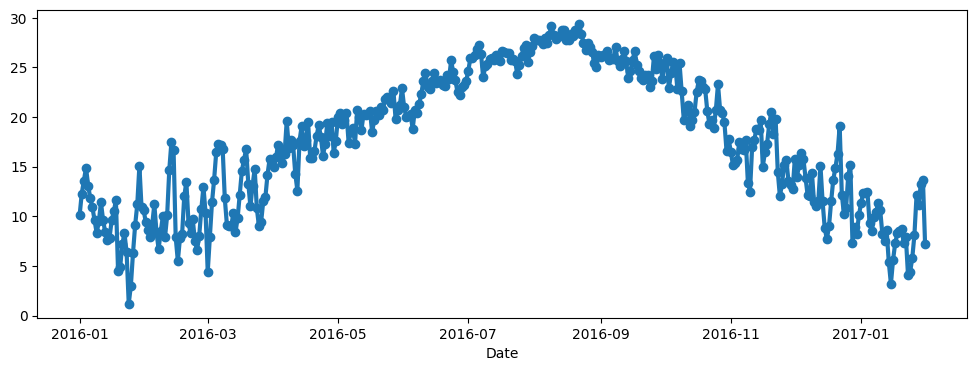

In [ ]:
amd.linefig(tim, Ta)

#### 例２
　同一メッシュ、同一期間の平年値も取得して参照線として追加し、さらに、要素名と単位も取得して凡例等を整えたグラフを描く。

　まず、平年値データを追加で取得します。

In [6]:
data,tim,lat,lon,nam,uni = amd.GetMetData(nani,itsu,doko,cli=True,namuni=True)  # 戻り値は6個になる
Tn = data[:,0,0]   #入れ物の入れ替え(3次元から1次元へ)

NameError: name 'nani' is not defined

　そのうえで、気象値と平年値を重ねて描画します。

In [3]:
amd.linefig(tim, Ta,
      title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
      ylabel=f'{nam}  [{uni}]',
      llabel='Aああああ',
      ref=Tn,
      llabelref='Normal Value')

NameError: name 'tim' is not defined

### 7.2 メッシュデータの分布図
　AMD_Tools4に含まれる関数 **mapfig** は、2次元配列のデータをシンプルな分布図として可視化します。

```Python
 AMD_Tools4.mapfig(arr,lat,lon,minmax=None,figsize=None,
               cmap='Spectral_r',figtitle='',barlabel='',
               filename=None,**kwargs)
```
引数(必須)：
* **arr**： 分布図にする２次元配列
* **lat**： 緯度値の配列
* **lon**： 経度値の配列
  
引数(必要なときだけ使用)：<br>
* **minmax**： カラースケールの範囲を指定する場合に2要素リストで[最小値, 最大値] を与える
* **figsize**： 分布図のサイズを指定する場合に、2要素リストで[横サイズ,縦サイズ]を与える
* **cmap**： 配色を指定する場合に、"カラースケール名"を文字列で指定する
* **figtitle**： 図の上に文字を表示する場合に、その文字列を与える
* **barlabel**: カラースケールに文字列を付ける場合に、その文字列を与える
* **filename**： 作画した分布図をPNGファイルで保存する場合に、"文字列.png"を与える。

戻り値：**なし**<br>

#### 例１
　室戸岬を含む広い範囲における2016年1月1日の日平均気温を取得し分布図を描画する。

In [ ]:
# 変数に取得条件を設定
nani = 'TMP_mea'
itsu = ['2016-01-01', '2016-01-01']
doko = [33.0, 35.0, 132.0, 136.0]

# 設定に基づき気象データを取得
data, tim, lat, lon, nam, uni = amd.GetMetData(nani, itsu, doko, namuni=True)
Ta = data[0,:,:]

TMP_mea (1, 241, 320) Tile


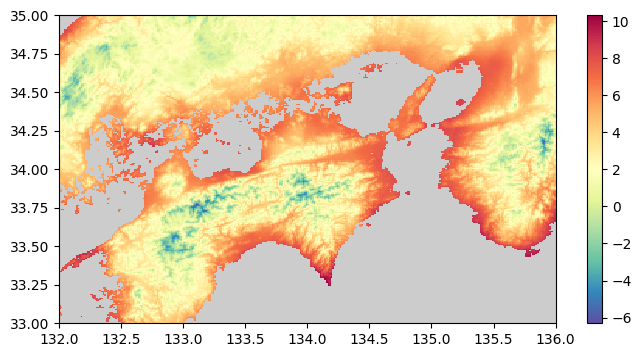

In [ ]:
amd.mapfig(Ta, lat, lon)

#### 例２
　同じ気温分布を、異なるカラースケール、異なるカラーマップで可視化するとともに、ファイル保存する。<br>
　関数の引数の括弧の中では、改行を自由に入れることができます。

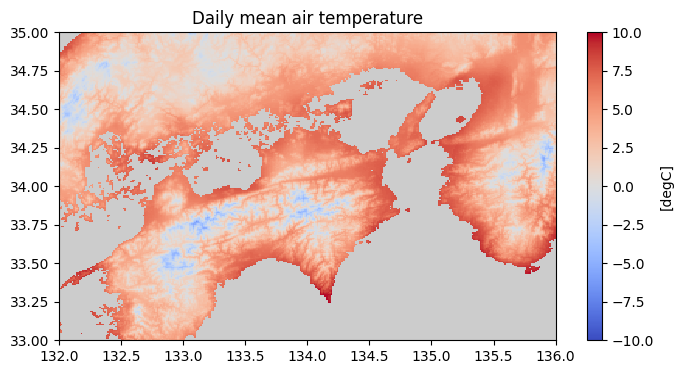

In [ ]:
amd.mapfig(Ta, lat, lon, minmax=[-10,10],
        figtitle=f'{nam}',
        barlabel=f'[{uni}]',
        filename='t4c72ex2.png',
        cmap='coolwarm')
# Python では、括弧の中では改行やインデントを自由にできます。

### 7.3 地理院地図へのオーバーレイ
　ライブラリ **AMD_Tools4** が提供する関数 **PutGSI_Map** を用いると、メッシュデータを地理院地図と重ね合わせて表示することができ、結果の詳細な確認が可能です。

　下を実行するとファイルが４つ新規作成されるので、その中の１つ **t4c73.html** をダブルクリックしてください。

In [ ]:
amd.PutGSI_Map(Ta, lat, lon, filename='t4c73')

　４つのファイルがあれば、PythonやJupyterがインストールされていなくとも、インターネットに接続されたPCでは、同じ図を表示させることが可能なので、結果の共有にも便利です。

```Python
AMD_Tools4.PutGSI_Map(data, lat, lon, label=None, cmapstr=None,
                      minmax=None, filename="result", outdir=".")
```
引数(必須)：<br>
* **data**：分布を表示させる２次元配列
* **lat**：緯度の１次元配列
* **lon**：経度の１次元配列

引数(必要なときだけ使用)：<br>
* **label**：凡例のタイトルの文字列
* **cmapstr**：カラーマップを指定（詳細は後述）
* **minmax**：カラースケールを指定（[min,max]のリスト）
* **filename**：出力ファイル名
* **outdir**：出力フォルダ名

カラーマップについて：<br>
　カラーマップには名称があるのでこれを文字列で("で囲んで)指定します。カラーサンプルは下記URLを参照のこと。<br>
https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html<br>
　なお、色の順序を反転させたい場合は、"rainbow_r" のよう名称の後ろに"_r"を付加します。

注意：<br>
　この関数は、numpy.datetime64[D]型(日時を表現するための数値)の配列も表示することができるので、日付の分布図を描画できます。但し、等値色の塗り方はメッシュ単位ではなく、メッシュ中心点の値を等高線で結ぶような描画になります。<br>
　また、オプション引数minmaxで配色の下限と上限を日付で指定する場合は、下記のようにして日付値を指定してください(datetimeオブジェクトで指定すると誤作動します)。<br>
```Python
    minmax = [np.datetime64('2018-08-25','D'),np.datetime64('2018-09-05','D')]
```

## 8 時別データの取得
メッシュ農業気象データでは時別値も公開しています。<br>
現在利用可能な気象要素は、気温（TMP）、相対湿度（RH）、下向き長波放射（DLR）の３種類です。平年値の節でも紹介したリンクに、時別値データの搭載期間について説明があるので参照してください。

https://amu.rd.naro.go.jp/wiki_open/doku.php?id=about#多彩な気象要素が用意されています

　時別値の取得には **GetMetDataHourly** 関数を使います。日別データの取得関数とほぼ同じ要領で使用できます。<br>
**GetMetDataHourly** 関数では、
- 取得する日時の範囲指定には、['2023-01-25T03, '2023-01-25T21'] のように **日付の後にTを付けて、時を２桁で記入**します。
- 時刻は 1時を示す **T01** から **T24** まで、一桁の場合はゼロで埋めた二桁の数値で指定します。
- 取得する時間の範囲に日付だけにすることも可能です。この場合、期間の最初の日の01時から、期間の最終日の24時までを取得します。


#### 例
　室戸岬の最突端の時別気温を2016年6月について取得し折れ線グラフにします。

In [ ]:
# 基本的な設定
nani = 'TMP'  # '気温' を指定
itsu = ['2016-06-01T01', '2016-06-30T24'] # 期間を指定。時刻まで指定したい場合は日付の後に T01-T24 を付ける。
doko = [ 33.3375, 33.3375,  132.00626, 132.00626 ]

# 気象データの取得
data, timh, lat, lon, nam, uni = amd.GetMetDataHourly(nani, itsu, doko, namuni=True)

TMP (721, 1, 1) Hourly


　上のスクリプトを実行し、「TMP (721, 1, 1)」と表示されたらデータは正常に取得されています。以下でデータのサイズも確認してください。

In [ ]:
data.shape

(720, 1, 1)

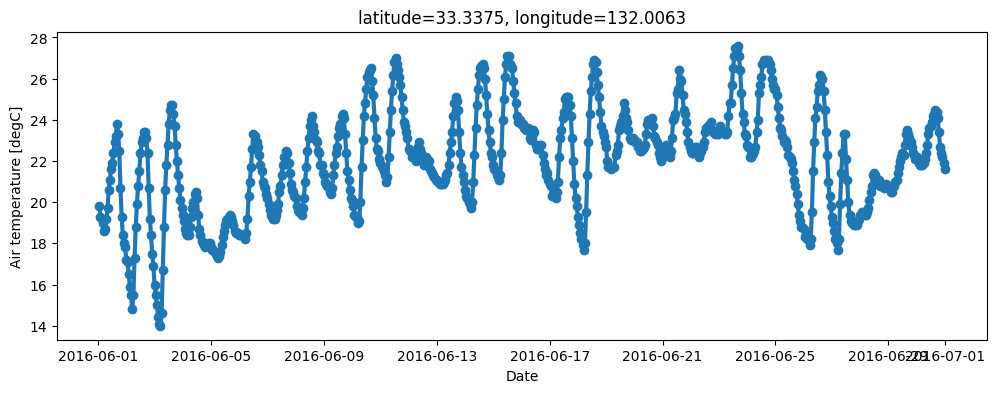

In [ ]:
Th = data[:,0,0]
lat_sc = lat[0]
lon_sc = lon[0]

amd.linefig(timh,Th,
         title=f'latitude={lat_sc:.4f}, longitude={lon_sc:.4f}',
         ylabel=f'{nam} [{uni}]')

## 9 温暖化シナリオデータの取得
メッシュ農業気象データでは全球気候モデルを用いた温暖化シナリオデータ(日別値)も３次メッシュで公開しています。<br>
利用可能な全球気候モデル、温暖化シナリオ、予測期間については、以下で確認してください。<br>
https://amu.rd.naro.go.jp/wiki_open/doku.php?id=scenalio

　シナリオデータの取得には **GetSceData** 関数を使います。モデルとシナリオを引数で指定する必要がありますが、それ以外は通常の日別データの取得関数と同じです。なお、温暖化シナリオデータには、平年値はありません。

```Python
AMD_Tools4.GetSceData(nani, itsu, doko, model, scenam,
                      namuni=False, url='https://amd.rd.naro.go.jp/opendap/AMS')
```
引数(必須)：<br>
* **nani**： 気象要素記号で、'TMP_mea'などの文字列で与える
* **itsu**： 取得するデータの時間範囲で、['2080-05-01', '2080-05-31'] のように文字列の2要素リストで与える。特定の日のデータを取得するときは二カ所に同じ日付を与える。
* **doko**： 取得するデータの緯度と経度の範囲で、[36.0, 40.0, 130.0, 135.0] のように緯度経度の順で範囲の最小値と最大値を指定する。特定メッシュのデータを取得するときは、それぞれの最小値と最大値に同じ値を与える。
* **model**：気候モデルの記号で、'MIROC5'などの文字列で与える
* **scenam**：排出シナリオ等の記号で、'RCP8.5'などの文字列で与える
  
引数(必要なときだけ使用)：<br>
* **namuni**: namuni=True とすると、関数の戻り値に、気象要素の正式名称と単位が追加される。
* **url**: 気象データを取り出す場所を指定する。省略した場合は**農研機構のデータ配信サーバー** からデータを取得する。

戻り値：<br>
* **第1戻り値**： 指定した気象要素の３次元(時刻、緯度、経度) 配列。範囲の指定の仕方にかかわらず常に３次元となる。
* **第2戻り値**： 切り出した気象データの緯度の１次元配列。値は浮動小数。
* **第3戻り値**： 切り出した気象データの経度の１次元配列。値は浮動小数。
* **第4戻り値**(引数に namuni=True を加えたときのみ)： 気象要素の正式名。文字列。
* **第5戻り値**(引数に namuni=True を加えたときのみ)： 気象要素の単位。文字列。

#### 例
　全球気候モデル **MIROC5** と、シナリオ **RCP8.5** で予測された茨城県つくば市内（舘野）における2100年の日最高気温のグラフを描く。

Cli_TMP_max (365, 1, 1) Tile
TMP_max (365, 1, 1) Tile MIROC5 RCP8.5)


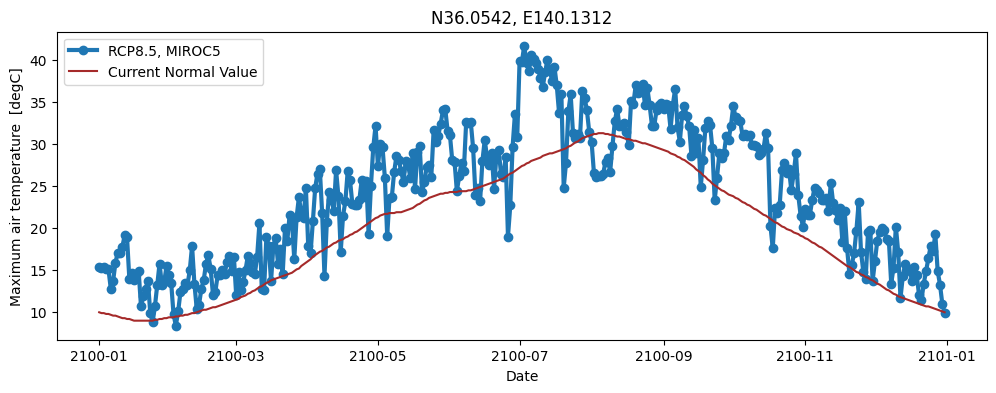

In [ ]:
# 気象データの取得
model = 'MIROC5'
scenario = 'RCP8.5'
nani = 'TMP_max'
doko = [ 36.0567, 36.0567, 140.1250, 140.1250 ]  #舘野

# 現在の平年値(平年値2020)の取得
itsu = ['2021-01-01', '2021-12-31']
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko, cli=True)
Tmax = data[:,0,0]

# シナリオデータの取得
itsu = ['2100-01-01', '2100-12-31']
data, tim, lat, lon, nam, uni = amd.GetSceData(nani, itsu, doko, model, scenario, namuni=True)
Tsmax = data[:,0,0]

# 折れ線グラフ
amd.linefig(tim, Tsmax,
      title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
      ylabel=f'{nam}  [{uni}]',
      llabel=f'{scenario}, {model}',
      ref=Tmax,
      llabelref='Current Normal Value')